In [1]:
%matplotlib inline

import h5py, os
import pyfftw
from pyfftw.interfaces.scipy_fftpack import fftn, ifftn
import pyprind
import matplotlib.pyplot as plt
import numpy
from scipy import stats

from wavelets import *

In [2]:
!ls ..

gravity.hdf5  minerals-groundwater-ML


In [35]:
# Parameters
fname = '../gravity.hdf5'
order = 0
n_angles, n_scales = 16, 20

In [36]:
# Get info from input signal
with h5py.File(fname) as src:
    spacing = (
        abs(src['Longitude'][1] - src['Longitude'][0]), 
        abs(src['Latitude'][1] - src['Latitude'][0]))
    nxs, nys, ndim = src['Raster'].shape
    shape = (nxs, nys)

    # Generate axes for transform
    scales = dgauss.generate_scales(n_scales, shape, spacing, order)
    angles = numpy.linspace(
        0, 2 * numpy.pi * (1 - 1 / n_angles), n_angles)
    axes = [
        (0, 'Angle', angles),
        (1, 'Scale', scales),
        (2, 'Longitude', src['Longitude'][...]),
        (3, 'Latitude', src['Latitude'][...]),
    ]
    
    # Remove NaNs and pad array...
    raster = src['Raster'][..., 0]
    mean = stats.nanmean(stats.nanmean(raster))
    raster[numpy.isnan(raster)] = mean
    pad_raster, pad_mask = pad_array(raster)
    pad_shape = pad_raster.shape
    fft_data = fftn(pad_raster)

/home/ubuntu/.local/conda/envs/wavelets/lib/python3.4/site-packages/scipy/stats/stats.py:316: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(x, axis) / factor


In [37]:
# Generate sink file
sink_fname = os.path.splitext(fname)[0] + '_deriv_order{0}.hdf5'.format(order)
with h5py.File(sink_fname) as sink:
    sink_shape = angles.shape + scales.shape + shape
    sink.require_dataset('Raster', shape=sink_shape, dtype=numpy.float64)

    # Attach dimension labels to raster, write to sink
    for idx, label, dim in axes:
        sink.require_dataset(name=label, 
                             shape=dim.shape, 
                             dtype=numpy.float64,
                             exact=True,
                             data=dim)
        sink['Raster'].dims.create_scale(dset=sink[label], name=label)
        sink['Raster'].dims[idx].attach_scale(sink[label])

    # Evaluate transforms
    progbar = pyprind.ProgBar(len(angles) * len(scales) + 1)
    freqs = fft_frequencies(pad_shape, spacing)
    for aidx, angle in enumerate(angles):
        rfreqs = rotate(freqs, (angles[0],))
        for sidx, scale in enumerate(scales):
            item = 'Angle: {0:0.2f} deg, Scale: {1:0.2f} deg'.format(angle * 180 / numpy.pi, scale)
            progbar.update(item_id=item)
            filtered = ifftn(fft_data * dgauss.dgauss_nd(rfreqs, order=order, scale=scale)).real
            sink['Raster'][aidx, sidx, ...] = filtered[pad_mask]

0%                          100%
[###############               ] | ETA[sec]: 490.465 | Item ID: Angle: 180.00 deg, Scale: 0.09 deg

RuntimeError: Can't decrement id ref count (File write failed: time = fri nov 20 03:51:07 2015
, filename = '../gravity_deriv_order0.hdf5', file descriptor = 91, errno = 28, error message = 'no space left on device', buf = 0x2b8b1b8, total write size = 2272, bytes this sub-write = 2272, bytes actually written = 18446744073709551615, offset = 4096)

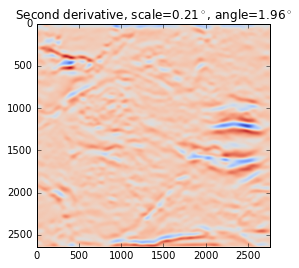

In [32]:
with h5py.File('../gravity_deriv_order2.hdf5') as sink:
    data = sink['Raster'][5, 5, ...]
    plt.imshow(data[:, ::-1].T, cmap='coolwarm', interpolation='none')
    plt.title(r'Second derivative, scale={0:0.2f}$^\circ$, angle={1:0.2f}$^\circ$'.format(sink['Scale'][5], sink['Angle'][5]))

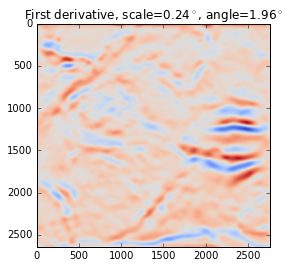

In [34]:
with h5py.File('../gravity_deriv_order1.hdf5') as sink:
    data = sink['Raster'][5, 5, ...]
    plt.imshow(data[:, ::-1].T, cmap='coolwarm', interpolation='none')
    plt.title(r'First derivative, scale={0:0.2f}$^\circ$, angle={1:0.2f}$^\circ$'.format(sink['Scale'][5], sink['Angle'][5]))